In [ ]:
!pip install scikit-surprise

In [ ]:
import numpy as np
import pandas as pd
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100)


import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_file = "/content/drive/MyDrive/AICapstone/ratings.csv.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("input/")

In [ ]:
df_ratings = pd.read_csv('input/ratings.csv')
df_ratings_copy=df_ratings.copy()
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
zip_file = "/content/drive/MyDrive/AICapstone/goodbooks_10k_rating_and_description.csv.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("input/")

book = pd.read_csv('input/goodbooks_10k_rating_and_description.csv')
book_copy=book.copy()
book.head()

,book_id,book_title,book_series,title,book_authors,genres,book_score,book_rating,book_rating_obj,book_rating_count,book_review_count,book_desc,tags,FE_text,book_desc_tags_FE,...,book_edition,book_format,original_publication_year,language_code,book_pages,book_pages_obj,books_count,books_count_obj,goodreads_book_id,book_isbn,isbn,isbn13,image_url_x,image_url_y,small_image_url
0,1,The Hunger Games,"The Hunger Games, #1","The Hunger Games (The Hunger Games, #1)",Suzanne Collins,Young Adult|Fiction|Science Fiction|Dystopia|F...,1.000000,4.33,4.0,5519135,160706,Winning will make you famous. Losing means cer...,to-read fantasy favorites currently-reading yo...,The-Hunger-Games Suzanne-Collins Young-Adult F...,Winning will make you famous. Losing means cer...,...,NaN,Hardcover,2008.0,eng,374.0,3.0,272,14.0,2767052,9.780440e+12,439023483,9.780439e+12,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603l...,https://images.gr-assets.com/books/1447303603s...
1,2,Harry Potter and the Philosopher's Stone,"Harry Potter, #1",Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",NaN,0.824569,4.44,4.0,6682936,108361,NaN,to-read fantasy favorites currently-reading yo...,Harry-Potter-and-the-Philosopher's-Stone J.K.-...,to-read fantasy favorites currently-reading y...,...,NaN,NaN,1997.0,eng,NaN,NaN,491,15.0,3,NaN,439554934,9.780440e+12,https://images.gr-assets.com/books/1474154022m...,NaN,https://images.gr-assets.com/books/1474154022s...
2,3,Twilight,"Twilight, #1","Twilight (Twilight, #1)",Stephenie Meyer,Young Adult|Fantasy|Romance|Paranormal|Vampire...,0.029020,3.58,3.5,4281268,97991,About three things I was absolutely positive.F...,to-read fantasy favorites currently-reading yo...,Twilight Stephenie-Meyer Young-Adult Fantasy R...,About three things I was absolutely positive.F...,...,NaN,Paperback,2005.0,en-US,498.0,4.0,226,14.0,41865,9.780320e+12,316015849,9.780316e+12,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443l...,https://images.gr-assets.com/books/1361039443s...
3,4,To Kill a Mockingbird,-,To Kill a Mockingbird,Harper Lee,Classics|Fiction|Historical|Historical Fiction...,0.231059,4.27,4.0,3745197,79450,The unforgettable novel of a childhood in a sl...,to-read favorites currently-reading young-adul...,To-Kill-a-Mockingbird Harper-Lee Classics Fict...,The unforgettable novel of a childhood in a sl...,...,50th Anniversary,Paperback,1960.0,eng,324.0,3.0,487,15.0,2657,9.780060e+12,61120081,9.780061e+12,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680l...,https://images.gr-assets.com/books/1361975680s...
4,5,The Great Gatsby,-,The Great Gatsby,F. Scott Fitzgerald,Classics|Fiction|Academic|School|Literature|Hi...,0.049427,3.90,3.5,3141842,56953,Alternate Cover Edition ISBN: 0743273567 (ISBN...,to-read favorites currently-reading young-adul...,The-Great-Gatsby F.-Scott-Fitzgerald Classics ...,Alternate Cover Edition ISBN: 0743273567 (ISBN...,...,US / CAN,Paperback,1925.0,eng,180.0,1.0,1356,15.0,4671,NaN,743273567,9.780743e+12,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560l...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
title_to_id = book.set_index('book_title')['book_id'].to_dict()

# Data Preparation

In [ ]:
df=df_ratings.merge(book[["book_id","book_title","book_authors"]],on="book_id")
df.head()

,user_id,book_id,rating,book_title,book_authors
0,1,258,5,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
1,11,258,3,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
2,143,258,4,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
3,242,258,5,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
4,325,258,4,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"


In [ ]:
def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)

check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911089 entries, 0 to 5911088
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       int64 
 1   book_id       int64 
 2   rating        int64 
 3   book_title    object
 4   book_authors  object
dtypes: int64(3), object(2)
memory usage: 225.5+ MB
None
--------------------     Data Shape     --------------------
(5911089, 5)

--------------------  The First 5 Data  --------------------
   user_id  book_id  rating            book_title                     book_authors
0        1      258       5  La sombra del viento  Carlos Ruiz Zafón, Lucia Graves
1       11      258       3  La sombra del viento  Carlos Ruiz Zafón, Lucia Graves
2      143      258       4  La sombra del viento  Carlos Ruiz Zafón, Lucia Graves
3      242      258       5  La sombra del viento  Carlos Ruiz Zafón, Lucia Graves
4      325      258       4  La sombr

In [ ]:
##
print(df.columns)
comment_counts = pd.DataFrame(df["book_title"].value_counts())
is_rare = comment_counts["count"] <=100

rare_books_index = comment_counts[is_rare].index

rare_books = list(rare_books_index)
common_books = df[~df["book_title"].isin(rare_books)]
common_books

Index(['user_id', 'book_id', 'rating', 'book_title', 'book_authors'], dtype='object')


,user_id,book_id,rating,book_title,book_authors
0,1,258,5,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
1,11,258,3,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
2,143,258,4,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
3,242,258,5,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
4,325,258,4,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
...,...,...,...,...,...
5911084,36773,9548,5,Vicious,L.J. Shen
5911085,50673,9548,4,Vicious,L.J. Shen
5911086,45213,9548,3,Vicious,L.J. Shen
5911087,12872,9548,4,Vicious,L.J. Shen


In [ ]:
user_book_df = common_books.pivot_table(index=["user_id"], columns=["book_title"], values="rating")
user_book_df

book_title,,A Monster Calls,Animal Farm & 1984,"Burned (Burned, #1)",Call the midwife : a true story of the East End in the 1950s,"Carry On, Warrior: Thoughts on Life Unarmed",Carter Beats the Devil,Crown of Shadows,Daemon,De Imitatione Christi,Evil at Heart,Faust. Der Tragödie erster und zweiter Teil,Feeling Good: The New Mood Therapy,Innocent Traitor,Kaleidoscope Hearts,...,花より男子 1,論語 [Lún Yǔ],象の消滅 [Zō no shōmetsu],走ることについて語るときに僕の語ること [Hashiru koto ni tsuite kataru toki ni boku no kataru koto],進撃の巨人 1,道德經 [dào dé jīng],鋼の錬金術師 1,雪国,青の祓魔師 1,高校デビュー 1,黑暗森林,黒執事 I [Kuroshitsuji I],黒執事 II [Kuroshitsuji II],엄마를 부탁해,채식주의자
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
random_user = int(pd.Series(user_book_df.index).sample(1).values)
random_user_df = user_book_df[user_book_df.index == random_user]
random_user_df

book_title,,A Monster Calls,Animal Farm & 1984,"Burned (Burned, #1)",Call the midwife : a true story of the East End in the 1950s,"Carry On, Warrior: Thoughts on Life Unarmed",Carter Beats the Devil,Crown of Shadows,Daemon,De Imitatione Christi,Evil at Heart,Faust. Der Tragödie erster und zweiter Teil,Feeling Good: The New Mood Therapy,Innocent Traitor,Kaleidoscope Hearts,...,花より男子 1,論語 [Lún Yǔ],象の消滅 [Zō no shōmetsu],走ることについて語るときに僕の語ること [Hashiru koto ni tsuite kataru toki ni boku no kataru koto],進撃の巨人 1,道德經 [dào dé jīng],鋼の錬金術師 1,雪国,青の祓魔師 1,高校デビュー 1,黑暗森林,黒執事 I [Kuroshitsuji I],黒執事 II [Kuroshitsuji II],엄마를 부탁해,채식주의자
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_books_read = random_user_df.columns[random_user_df.notna().any()].tolist()
#all_books_read


In [ ]:
#將選取出已讀書籍的評分資料，存入名為 books_read_df 的 DataFrame 中。
#這個 DataFrame 包含了使用者已經閱讀過的書籍的評分資料，其中索引是使用者 ID，欄位是已閱讀書籍的標題，而值是該使用者對每本已閱讀書籍的評分。
#----------------------------------------------------------------------------------------------------
temp = all_books_read
total_books = len(all_books_read)

# 找到前 50% 的書籍數量
top_count = int(total_books * 0.5)

#books_read = all_books_read[:top_count]

#remaining_books = temp[top_count:]

books_read = [book for i, book in enumerate(all_books_read) if i % 2 != 0]
remaining_books = [book for i, book in enumerate(all_books_read) if i % 2 == 0]
#-----------------------------------------------------------------------------------------------------

top_count_ids = [title_to_id[title] for title in books_read]
remaining_books_count_ids = [title_to_id[title] for title in remaining_books]

top_count_ids_str = ', '.join(str(book_id) for book_id in top_count_ids)
remaining_books_count_ids_str = ', '.join(str(book_id) for book_id in remaining_books_count_ids)

print(top_count_ids_str)
print()
print(remaining_books_count_ids_str)
print()

books_read

5438, 401, 595, 6587, 1725, 29, 6702, 621, 223, 354, 405, 75, 158, 1579, 7970, 727, 372, 4439, 395, 409, 30, 160, 888, 77, 4511, 5590, 1283, 335, 80, 1040, 45, 8260, 608, 538, 16, 6919, 358, 129, 3740, 10, 1582, 762, 180, 2035, 646, 116, 178, 251, 198, 512, 26, 85, 488, 964, 1, 1695, 6724, 44, 90, 95, 138, 390, 399, 627, 296, 416, 2145, 293, 819, 46, 9550, 321, 102, 5816, 63, 177

1875, 1622, 278, 83, 661, 5520, 14, 3415, 605, 212, 7186, 245, 728, 59, 1635, 905, 12, 2062, 851, 71, 1810, 66, 157, 21, 364, 721, 181, 386, 103, 1679, 3597, 4847, 28, 184, 8602, 1981, 268, 798, 9822, 9933, 270, 4455, 1162, 1641, 9793, 58, 373, 375, 8, 1492, 2209, 6850, 5, 31, 941, 507, 391, 5926, 130, 68, 4338, 1402, 264, 3037, 2021, 547, 8771, 4, 2948, 707, 896, 534, 50, 935, 3618, 172, 472



['A Color of His Own',
 'A Farewell to Arms',
 'A Separate Peace',
 'Affinity',
 "Alice's Adventures in Wonderland",
 'An Excellent conceited Tragedie of Romeo and Juliet',
 'Animalia',
 "Are You There God? It's Me, Margaret",
 'Artemis Fowl',
 'Beloved',
 'Breakfast of Champions',
 "Bridget Jones's Diary ",
 'Charlie and the Chocolate Factory',
 'Chelsea Chelsea Bang Bang',
 'Close Range: Wyoming Stories',
 'Der Vorleser',
 'Dress Your Family in Corduroy and Denim',
 'Five Little Monkeys Jumping on the Bed (The Five Little Monkeys)',
 'For Whom the Bell Tolls',
 'Fried Green Tomatoes at the Whistle Stop Cafe',
 'Gone Girl',
 'Great Expectations',
 'Harold and the Purple Crayon',
 'Holes',
 'How to Tell If Your Cat Is Plotting to Kill You',
 'If You Give a Pig a Party (If You Give...)',
 'Ishmael: An Adventure of the Mind and Spirit',
 'James and the Giant Peach',
 'Le Petit Prince',
 'Lets Explore Diabetes with Owls',
 'Life of Pi',
 'Lon Po Po',
 'Love You Forever',
 'Midnight in the

In [ ]:
total_books

153

In [ ]:
books_read_df = user_book_df[books_read]
books_read_df

book_title,A Color of His Own,A Farewell to Arms,A Separate Peace,Affinity,Alice's Adventures in Wonderland,An Excellent conceited Tragedie of Romeo and Juliet,Animalia,"Are You There God? It's Me, Margaret",Artemis Fowl,Beloved,Breakfast of Champions,Bridget Jones's Diary,Charlie and the Chocolate Factory,Chelsea Chelsea Bang Bang,Close Range: Wyoming Stories,...,The Strange Case of Dr Jekyll and Mr Hyde,The Tales of Beedle the Bard,The True Story of the Three Little Pigs,The Very Hungry Caterpillar,The Witches,Tipping the Velvet,Treasure Island,Walden; or Life in the Woods,Water for Elephants,When Will Jesus Bring the Pork Chops?,Where the Red Fern Grows,Where the Wild Things Are,Why Mosquitoes Buzz in People's Ears: A West African Tale,Wuthering Heights,Преступление и наказание
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53420,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
53421,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
53422,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


In [ ]:
user_book_count = books_read_df.T.notnull().sum()
user_book_count = user_book_count.reset_index()
user_book_count.columns = ["user_id", "book_count"]
user_book_count

,user_id,book_count
0,1,11
1,2,5
2,3,5
3,4,13
4,5,0
...,...,...
53419,53420,10
53420,53421,5
53421,53422,8
53422,53423,6


In [ ]:
ratio= 20 #原本20
perc = len(books_read) * ratio / 100
perc

15.2

In [ ]:
users_same_books = user_book_count[user_book_count["book_count"] > perc]["user_id"]
users_same_books

31          32
64          65
78          79
84          85
144        145
         ...  
53280    53281
53292    53293
53331    53332
53341    53342
53356    53357
Name: user_id, Length: 1920, dtype: int64

In [ ]:
#建立了最終的相關係數資料表 final_df。首先，從 books_read_df 中選擇了擁有與目標使用者相似閱讀習慣的使用者的評分資料。接著，將隨機選擇的使用者對應的書籍評分加入其中。
#這樣，final_df 中包含了與目標使用者有相似閱讀習慣的一組使用者的評分資料。然後，程式碼計算了這些書籍的相關係數，以了解它們之間的相似性。它將 final_df 轉置後計算相關係數，
#然後對結果進行排序、去除重複值，最終將相關係數存儲在 corr_df 中。
from sklearn.metrics.pairwise import cosine_similarity


final_df = pd.concat([books_read_df[books_read_df.index.isin(users_same_books)],
                        random_user_df[books_read]])
'''
corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
corr_df'''
#--------------------------------------------------------------------------------------------------------------------------

# Calculate cosine similarity
cosine_sim = cosine_similarity(final_df.fillna(0))
cosine_sim_df = pd.DataFrame(cosine_sim, index=final_df.index, columns=final_df.index)

# 將 cosine similarity 轉換為 DataFrame
cosine_sim_df = cosine_sim_df.unstack().sort_values(ascending=False).drop_duplicates()
cosine_sim_df = pd.DataFrame(cosine_sim_df, columns=["cosine_sim"])
cosine_sim_df.index.names = ['user_id_1', 'user_id_2']
cosine_sim_df = cosine_sim_df.reset_index()

# Remove rows where user_id_1 is equal to user_id_2
cosine_sim_df = cosine_sim_df[cosine_sim_df["user_id_2"] != random_user]


# 設置相似度閾值
cos_th = 0.3
top_users = cosine_sim_df[(cosine_sim_df["user_id_1"] == random_user) & (cosine_sim_df["cosine_sim"] >= cos_th)][
    ["user_id_2", "cosine_sim"]].reset_index(drop=True)
top_users = top_users.sort_values(by='cosine_sim', ascending=False)

top_users.rename(columns={"user_id_2": "user_id"}, inplace=True)
top_users_ratings = top_users.merge(df_ratings[["user_id", "book_id", "rating"]], how='inner')
top_users_ratings['weighted_rating'] = top_users_ratings['cosine_sim'] * top_users_ratings['rating']
#------------------------------------------------------------------------------------------------------------------------

In [ ]:
#corr_df = pd.DataFrame(corr_df, columns=["corr"])
#corr_df

In [ ]:
#corr_df.index.names = ['user_id_1', 'user_id_2']
#corr_df = corr_df.reset_index()
#corr_df

,user_id_1,user_id_2,corr
0,13558,26107,-1.0
1,31172,24993,-1.0
2,19261,8591,-1.0
3,2247,2885,-1.0
4,31162,29361,-1.0
...,...,...,...
362030,51458,16826,1.0
362031,25233,33245,1.0
362032,14546,1296,1.0
362033,12143,4934,1.0


In [ ]:
"""cor_th=0.3
top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >= cor_th)][
        ["user_id_2", "corr"]].reset_index(drop=True)
top_users = top_users.sort_values(by='corr', ascending=False)
top_users"""

,user_id_2,corr
538,48757,0.987479
537,24439,0.973833
536,52024,0.956463
535,10703,0.946762
534,43561,0.937043
...,...,...
4,51047,0.302346
3,51047,0.302346
2,8750,0.302122
1,14259,0.301369


In [ ]:
"""top_users.rename(columns={"user_id_2": "user_id"}, inplace=True)
top_users_ratings = top_users.merge(df_ratings[["user_id", "book_id", "rating"]], how='inner')
top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']
top_users_ratings"""

,user_id,corr,book_id,rating,weighted_rating
0,48757,0.987479,16,4,3.949917
1,48757,0.987479,98,4,3.949917
2,48757,0.987479,140,4,3.949917
3,48757,0.987479,620,3,2.962438
4,48757,0.987479,8132,3,2.962438
...,...,...,...,...,...
70543,38441,0.300731,3270,5,1.503656
70544,38441,0.300731,1260,3,0.902194
70545,38441,0.300731,695,5,1.503656
70546,38441,0.300731,3963,5,1.503656


In [ ]:
recommendation_df = top_users_ratings.groupby('book_id').agg({"weighted_rating": "mean"})
recommendation_df = recommendation_df.reset_index()
recommendation_df

,book_id,weighted_rating
0,1,2.013057
1,2,2.042802
2,3,1.437423
3,4,2.107541
4,5,1.864337
...,...,...
6901,9994,2.115277
6902,9995,1.650340
6903,9997,2.262751
6904,9998,2.388908


In [ ]:
score=2
books_recommend = recommendation_df[recommendation_df["weighted_rating"] > score].sort_values("weighted_rating", ascending=False)

In [ ]:
books_recommend=books_recommend.merge(book[["book_id", "book_title"]])
books_recommend

,book_id,weighted_rating,book_title
0,8709,3.123456,Instructions for a Heatwave
1,9129,3.123456,Glue
2,8100,3.123456,How to Save a Life
3,1767,3.123456,The Sky Is Everywhere
4,8473,3.123456,If You Find Me
...,...,...,...
1800,4646,2.000470,Chicken Soup with Rice: A Book of Months
1801,181,2.000381,In Cold Blood
1802,846,2.000132,Animal Farm & 1984
1803,7575,2.000104,Double Indemnity


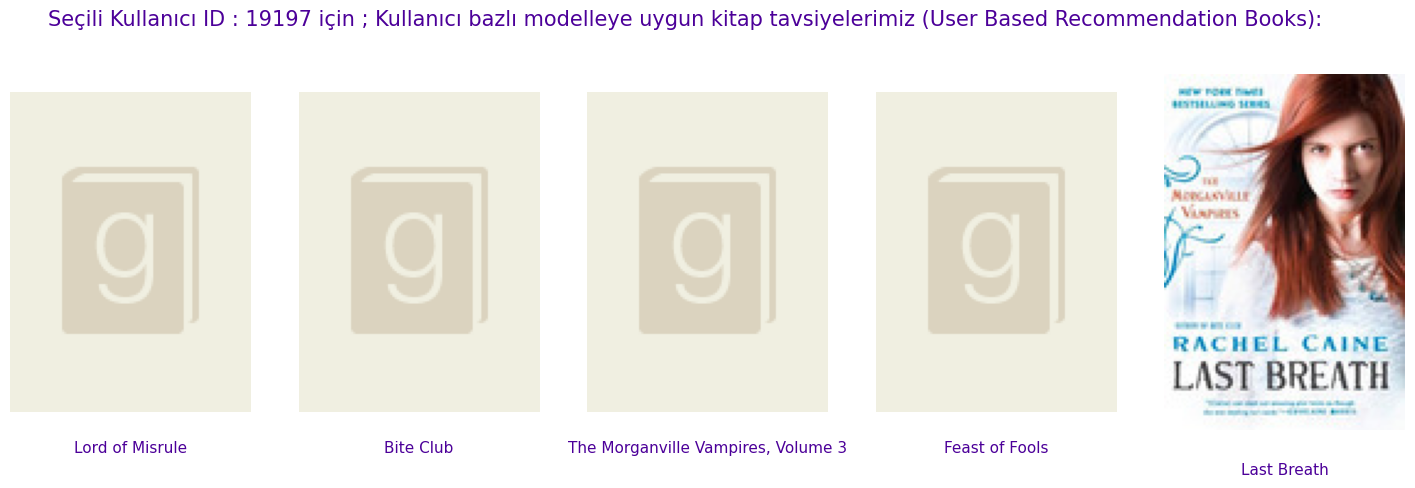

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests


fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('Seçili Kullanıcı ID : {}'.format(random_user)+ ' için ; Kullanıcı bazlı modelleye uygun kitap tavsiyelerimiz (User Based Recommendation Books):', color="#4C0099",size = 15)
for i in range(5):

                url = book.loc[book['book_title'] == books_recommend['book_title'].tolist()[i],'image_url_x'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('{}'.format(books_recommend['book_title'].tolist()[i]), y=-0.15,color="#4C0099",fontsize=11)


fig.show()


In [ ]:
recommended_books_in_remaining = []

# Convert the 'book_title' column to a list once and store it in a variable
book_titles_list = books_recommend["book_title"].tolist()

# Loop through each of the recommended books
for recommended_book_title in book_titles_list:
    # Check if the recommended book title is in the remaining books
    if recommended_book_title in remaining_books:
        # Get the row of the recommended book
        book_row = books_recommend[books_recommend["book_title"] == recommended_book_title]
        # Extract the book title and weighted rating
        book_info = {
            "book_title": recommended_book_title,
            "weighted_rating": book_row["weighted_rating"].values[0]
        }
        # Append the book info to the list
        recommended_books_in_remaining.append(book_info)

# Print the recommended books that are in the remaining 20% of the books read
print("Recommended books in the remaining 20% of the books read:")
for book_info in recommended_books_in_remaining:
    print(f"Title: {book_info['book_title']}, Weighted Rating: {book_info['weighted_rating']}")

print(len(recommended_books_in_remaining))
print(len(remaining_books))

Recommended books in the remaining 20% of the books read:
Title: Strangers on a Train, Weighted Rating: 2.583659392797001
Title: Furiously Happy, Weighted Rating: 2.268955327170971
Title: The Hunger Games Box Set, Weighted Rating: 2.216492507583415
Title: The Lorax, Weighted Rating: 2.1502744780918195
Title: How the Grinch Stole Christmas!, Weighted Rating: 2.134410901816277
Title: The Complete Works, Weighted Rating: 2.1339406740780285
Title: Lilly's Purple Plastic Purse, Weighted Rating: 2.1244124162093554
Title: Where the Sidewalk Ends: The Poems and Drawings of Shel Silverstein, Weighted Rating: 2.1153992617047317
Title: To Kill a Mockingbird, Weighted Rating: 2.107541390885106
Title: Hyperbole and a Half: Unfortunate Situations, Flawed Coping Mechanisms, Mayhem, and Other Things That Happened, Weighted Rating: 2.099087601611604
Title: A Light in the Attic, Weighted Rating: 2.0945096808203885
Title: The BFG, Weighted Rating: 2.0939567477939636
Title: There's a Nightmare in My Close

In [ ]:
top_count_ids_str

'5438, 401, 595, 6587, 1725, 29, 6702, 621, 223, 354, 405, 75, 158, 1579, 7970, 727, 372, 4439, 395, 409, 30, 160, 888, 77, 4511, 5590, 1283, 335, 80, 1040, 45, 8260, 608, 538, 16, 6919, 358, 129, 3740, 10, 1582, 762, 180, 2035, 646, 116, 178, 251, 198, 512, 26, 85, 488, 964, 1, 1695, 6724, 44, 90, 95, 138, 390, 399, 627, 296, 416, 2145, 293, 819, 46, 9550, 321, 102, 5816, 63, 177'

In [ ]:
remaining_books_count_ids_str

'1875, 1622, 278, 83, 661, 5520, 14, 3415, 605, 212, 7186, 245, 728, 59, 1635, 905, 12, 2062, 851, 71, 1810, 66, 157, 21, 364, 721, 181, 386, 103, 1679, 3597, 4847, 28, 184, 8602, 1981, 268, 798, 9822, 9933, 270, 4455, 1162, 1641, 9793, 58, 373, 375, 8, 1492, 2209, 6850, 5, 31, 941, 507, 391, 5926, 130, 68, 4338, 1402, 264, 3037, 2021, 547, 8771, 4, 2948, 707, 896, 534, 50, 935, 3618, 172, 472'

In [ ]:
del recommendation_df
del books_recommend
del top_users
del final_df
del corr_df
del user_book_df